In [34]:
!pip install torch_geometric
!pip install optuna

In [35]:
import torch
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv

In [36]:
dataset=KarateClub()
data=dataset[0]

In [37]:
print(dataset.num_features)

34


In [38]:
import pandas as pd

# Node features DataFrame
node_features_df = pd.DataFrame(
    data.x.numpy(),
    columns=[f'feature_{i}' for i in range(data.x.shape[1])]
)
node_features_df['node'] = node_features_df.index
node_features_df.set_index('node', inplace=True)

# Edge index DataFrame
edge_index_df = pd.DataFrame(
    data.edge_index.numpy().T,
    columns=['source', 'target']
)

# Labels DataFrame
labels_df = pd.DataFrame(
    data.y.numpy(),
    columns=['label']
)
labels_df['node'] = labels_df.index
labels_df.set_index('node', inplace=True)


In [39]:
print(node_features_df)

      feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
node                                                                     
0           1.0        0.0        0.0        0.0        0.0        0.0   
1           0.0        1.0        0.0        0.0        0.0        0.0   
2           0.0        0.0        1.0        0.0        0.0        0.0   
3           0.0        0.0        0.0        1.0        0.0        0.0   
4           0.0        0.0        0.0        0.0        1.0        0.0   
5           0.0        0.0        0.0        0.0        0.0        1.0   
6           0.0        0.0        0.0        0.0        0.0        0.0   
7           0.0        0.0        0.0        0.0        0.0        0.0   
8           0.0        0.0        0.0        0.0        0.0        0.0   
9           0.0        0.0        0.0        0.0        0.0        0.0   
10          0.0        0.0        0.0        0.0        0.0        0.0   
11          0.0        0.0        0.0 

In [40]:
num_nodes=data.num_nodes
print(f"Number of nodes: {num_nodes}")

Number of nodes: 34


In [41]:
num_edges=data.edge_index.shape[1]
print(f"Number of edges: {num_edges}")

Number of edges: 156


In [42]:
print(f"\nEdge indices (shape: {edge_index_df.shape}):")
print(edge_index_df.head())


Edge indices (shape: (156, 2)):
   source  target
0       0       1
1       0       2
2       0       3
3       0       4
4       0       5


In [43]:
print(f"\nLabels (shape: {labels_df.shape}):")
print(labels_df.head())


Labels (shape: (34, 1)):
      label
node       
0         1
1         1
2         1
3         1
4         3


In [44]:
num_countries=4
np.random.seed(42)
countries=torch.tensor(np.random.choice(num_countries,data.num_nodes))
data.y=countries

In [45]:
print(data)
print(f'x = {data.x.shape}')
print(data.x)
print(f'edge_index={data.edge_index.shape}')
print(data.edge_index)
print(f'y={data.y.shape}')
print(data.y)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
x = torch.Size([34, 34])
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
edge_index=torch.Size([2, 156])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32

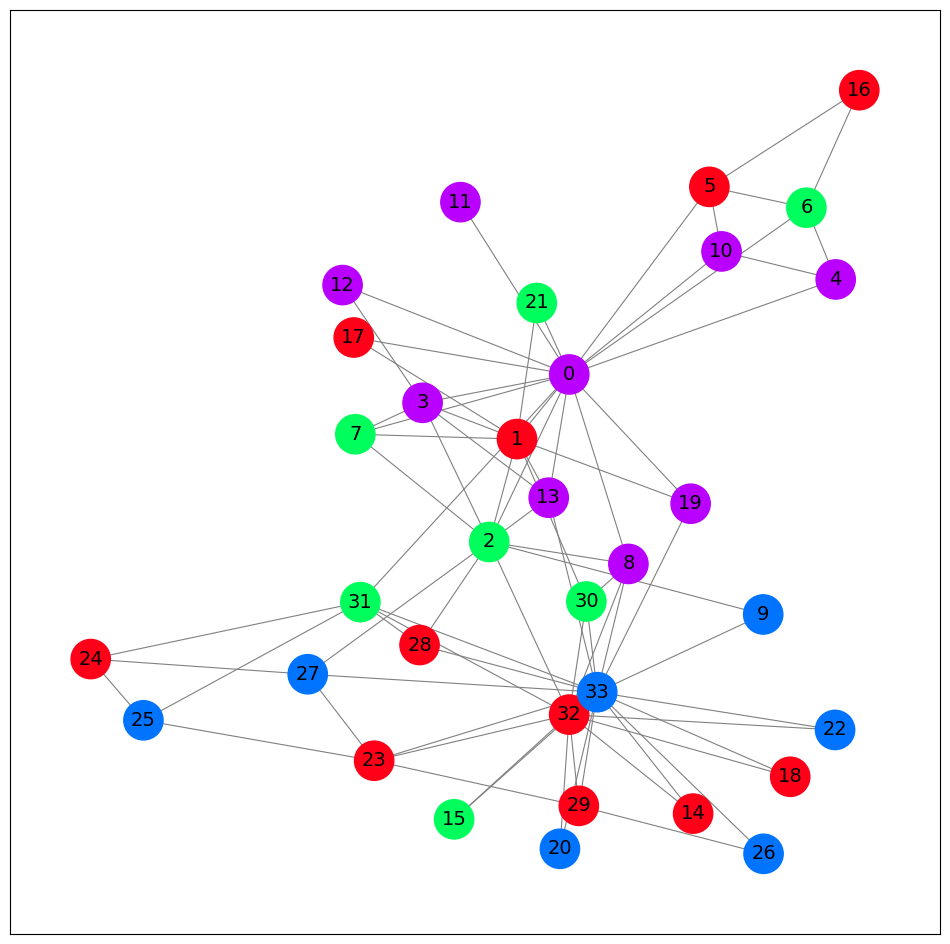

In [46]:
G=to_networkx(data,to_undirected=True)
plt.figure(figsize=(12,12))
plt.axis('on')
nx.draw_networkx(G,
    pos=nx.spring_layout(G,seed=0),
    with_labels=True,
    node_size=800,
    node_color=data.y,
    cmap="hsv",
    vmin=-2,
    vmax=3,
    width=0.8,
    edge_color="grey",
    font_size=14
)
plt.show()

In [47]:
class GCN(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.gcn=GCNConv(dataset.num_features,3)
    self.out=Linear(3,num_countries)
  def forward(self,x,edge_index):
    h=self.gcn(x,edge_index).relu()
    z=self.out(h)
    return h,z

model=GCN()
print(model)

GCN(
  (gcn): GCNConv(34, 3)
  (out): Linear(in_features=3, out_features=4, bias=True)
)


In [48]:
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.02)
def accuracy(pred_y,y):
  return (pred_y==y).sum()/len(y)

In [49]:
embeddings=[]
losses=[]
accuracies=[]
outputs=[]

for epoch in range(200):
  optimizer.zero_grad()
  h,z=model(data.x,data.edge_index)
  loss=criterion(z,data.y)
  loss.backward()
  optimizer.step()

  # Calculate accuracy inside the loop
  acc = accuracy(z.argmax(dim=1), data.y)

  embeddings.append(h) # Ensure h is a tensor being appended
  losses.append(loss)
  accuracies.append(acc)
  outputs.append(z.argmax(dim=1))
  if epoch%10==0:
    print(f'Epoch {epoch:>3}| Loss:{loss:.2f} | Accuracy:{acc:.2f}%')

Epoch   0| Loss:1.45 | Accuracy:0.21%
Epoch  10| Loss:1.32 | Accuracy:0.32%
Epoch  20| Loss:1.18 | Accuracy:0.32%
Epoch  30| Loss:1.04 | Accuracy:0.56%
Epoch  40| Loss:0.90 | Accuracy:0.65%
Epoch  50| Loss:0.77 | Accuracy:0.68%
Epoch  60| Loss:0.66 | Accuracy:0.91%
Epoch  70| Loss:0.55 | Accuracy:0.91%
Epoch  80| Loss:0.45 | Accuracy:0.94%
Epoch  90| Loss:0.37 | Accuracy:0.94%
Epoch 100| Loss:0.29 | Accuracy:0.97%
Epoch 110| Loss:0.24 | Accuracy:0.97%
Epoch 120| Loss:0.19 | Accuracy:0.97%
Epoch 130| Loss:0.16 | Accuracy:1.00%
Epoch 140| Loss:0.13 | Accuracy:1.00%
Epoch 150| Loss:0.11 | Accuracy:1.00%
Epoch 160| Loss:0.10 | Accuracy:1.00%
Epoch 170| Loss:0.08 | Accuracy:1.00%
Epoch 180| Loss:0.07 | Accuracy:1.00%
Epoch 190| Loss:0.06 | Accuracy:1.00%


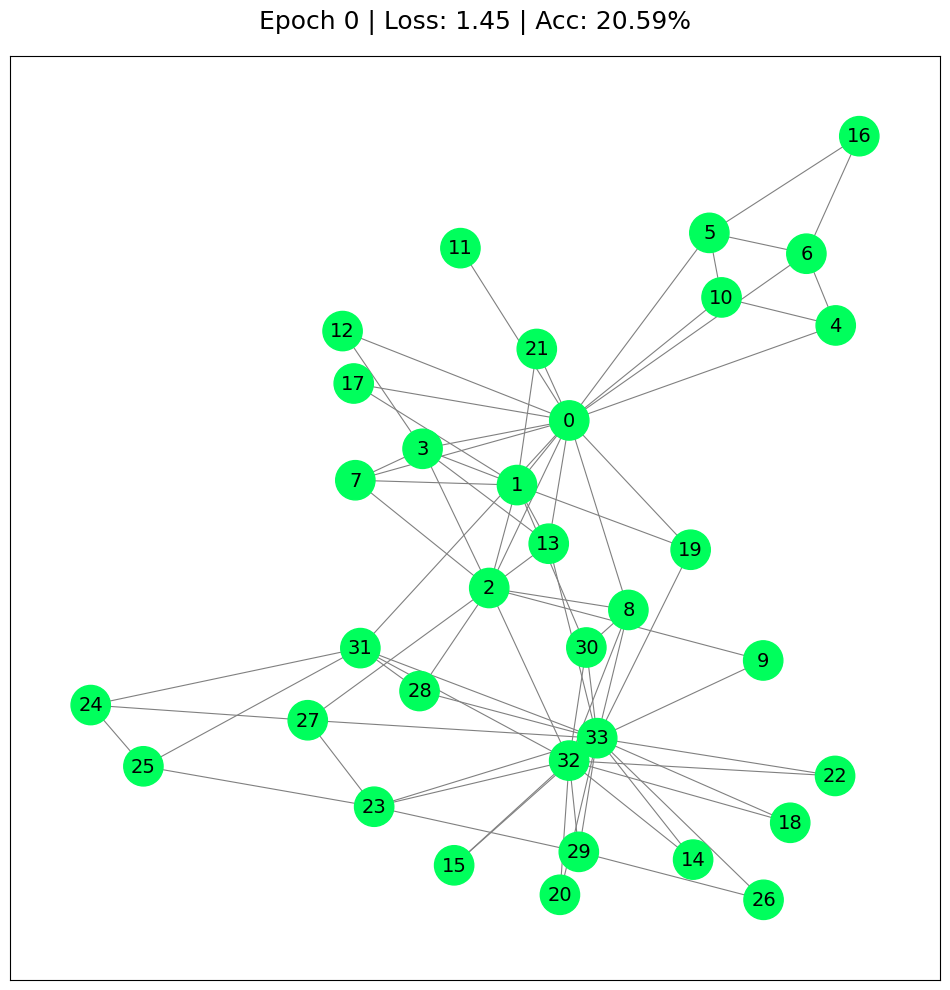

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx
from IPython.display import HTML, display
from matplotlib import animation

plt.rcParams["animation.bitrate"] = 3000

def animate(i):
    plt.clf()  # Clear the previous frame
    G = to_networkx(data, to_undirected=True)
    pos = nx.spring_layout(G, seed=0)
    nx.draw_networkx(
        G,
        pos=pos,
        with_labels=True,
        node_size=800,
        node_color=outputs[i].numpy(),
        cmap="hsv",
        vmin=-2,
        vmax=3,
        width=0.8,
        edge_color="grey",
        font_size=14
    )
    plt.title(
        f'Epoch {i} | Loss: {losses[i].item():.2f} | Acc: {accuracies[i].item() * 100:.2f}%',
        fontsize=18, pad=20
    )

fig = plt.figure(figsize=(12, 12))
plt.axis('on')
anim = animation.FuncAnimation(fig, animate, frames=np.arange(0, 200, 10), interval=500, repeat=True)

html = HTML(anim.to_html5_video())
display(html)


Final embeddings=torch.Size([34, 3])
tensor([[0.0000e+00, 1.7942e+00, 2.3582e-02],
        [0.0000e+00, 7.6083e-01, 9.6930e-01],
        [4.0743e-01, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 9.7402e-01, 0.0000e+00],
        [0.0000e+00, 1.1112e+00, 0.0000e+00],
        [4.4617e-03, 1.1784e+00, 1.2254e+00],
        [2.6868e-01, 8.8996e-04, 7.9515e-02],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 8.2579e-01, 0.0000e+00],
        [2.2152e+00, 1.4431e-01, 6.2549e-01],
        [9.1803e-04, 1.1043e+00, 0.0000e+00],
        [1.5812e-03, 2.0717e+00, 0.0000e+00],
        [0.0000e+00, 1.6920e+00, 0.0000e+00],
        [5.6805e-02, 1.0229e+00, 0.0000e+00],
        [1.0073e+00, 1.2268e+00, 1.3052e+00],
        [4.6819e-01, 0.0000e+00, 0.0000e+00],
        [4.1294e-01, 2.0392e-01, 1.2704e+00],
        [6.8220e-01, 8.8614e-01, 9.8844e-01],
        [8.6461e-01, 1.1155e+00, 1.2730e+00],
        [8.7711e-02, 9.3367e-01, 0.0000e+00],
        [1.6066e+00, 0.0000e+00, 1.0027e+00

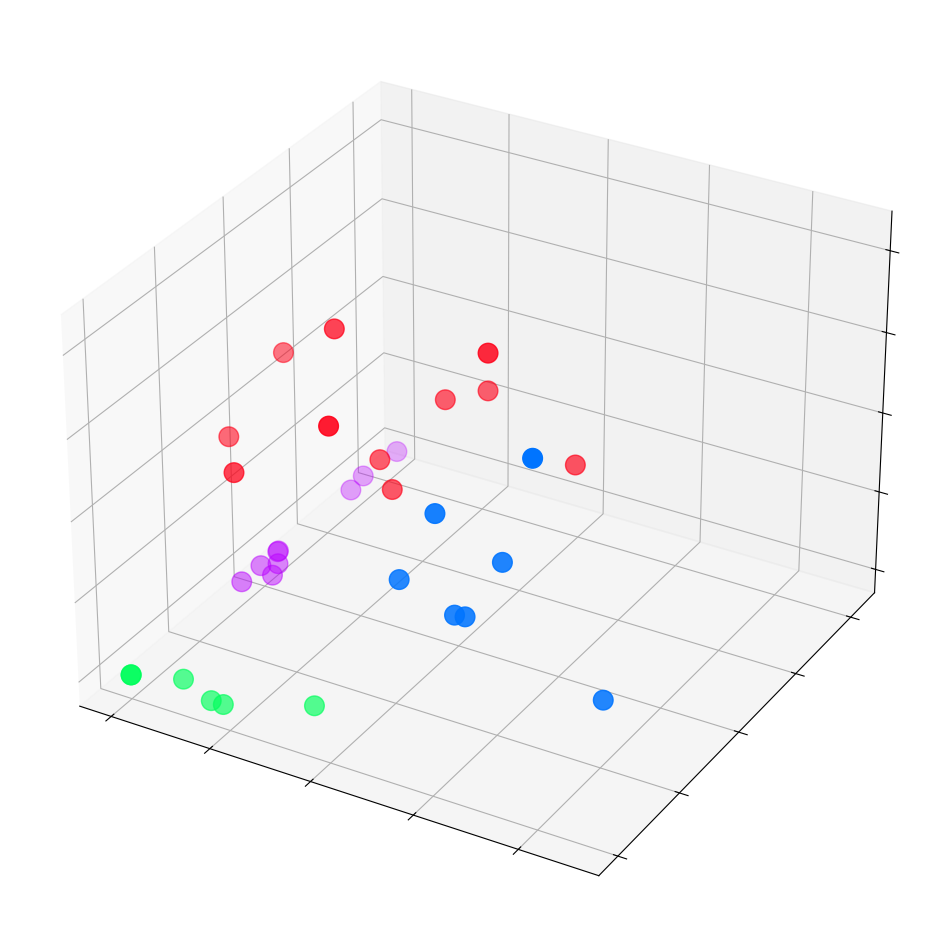

In [51]:
#3D Embeddings

print(f'Final embeddings={h.shape}')
print(h)

embed = h.detach().cpu().numpy()
fig=plt.figure(figsize=(12,12))
ax=fig.add_subplot(111,projection='3d')
ax.patch.set_alpha(0)
plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
ax.scatter(embed[:,0],embed[:,1],embed[:,2],
           s=200,c=data.y,cmap="hsv",vmin=-2,vmax=3)
plt.show()

def animate_3d(i):
  embed=embeddings[i].detach().cpu.numpy()
  ax.clear()
  ax.scatter(embed[:,0],embed[:,1],embed[:,2],
             s=200,c=data.y,cmap="hsv",vmin=-2,vmax=3)
  plt.title(f'Epoch {i} | Losses: {losses[i].item():.2f} | Acc:{accuracies[i].item()*100:.2f}%',
            fontsize=18,pad=40)
  fig=plt.figure(figsize=(12,12))
  plt.axis('on')
  ax=fig.add_subplot(projection='3d')
  plt.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
  anim=animation.FuncAnimation(fig,animate_3d,frames=np.arange(0,200,10),interval=800,repeat=True)
  html=HTML(anim.to_html5_video())
  display(html)